In [1]:
''' RNN Bidireccional en Keras '''
__author__ = '@Tssp'
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from codvidutils.Transformation_class import Transformation
import tensorflow as tf
from keras.layers import Conv2D, Input, Dense, MaxPooling2D, UpSampling2D, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

Using TensorFlow backend.


In [5]:
trns = Transformation('data/train_split_v4.csv', 'data/test_split_v5.csv')
#------------Read images and prepare dataset------------#
train_class, test_class = trns.read_imgs_paths()
X_train, X_test, diseaseID_train, diseaseID_test = trns.read_imgs(train_class, test_class)
del train_class, test_class
#------------Imbalanced methods------------#
X_train, X_test, diseaseID_train = trns.underbalance(X_train, X_test, diseaseID_train)
print('X_train.shape: {}\nX_test.shape: {}'.format(X_train.shape, X_test.shape))
print("Normal train: ",diseaseID_train[diseaseID_train==0].shape)
print("Pneumonia train: ",diseaseID_train[diseaseID_train==2].shape)
print("COVID train: ",diseaseID_train[diseaseID_train==1].shape)
print("*******************************************************")
print("Normal test: ",diseaseID_test[diseaseID_test==0].shape)
print("Pneumonia test: ",diseaseID_test[diseaseID_test==2].shape)
print("COVID test: ",diseaseID_test[diseaseID_test==1].shape)
X_train, X_test, diseaseID_train, diseaseID_test = trns.new_imgs(X_train, X_test, diseaseID_train, diseaseID_test)
Y_train = np.copy(diseaseID_train)
del diseaseID_train
Y_train[Y_train==2]=0
Y_test = np.copy(diseaseID_test)
Y_test[Y_test==2]=0
X_test = X_test/255
X_train = X_train/255

You are going to read from: data/train_split_v4.csv and data/test_split_v5.csv
Total number of images: 1524
shape X: 13600 1524,  disease_ID (Y): 13600 1524
Count of classes:  Counter({0: 7966, 2: 5447, 1: 187})
New diseaseID shape:  (9097,)
New X shape:  (9097, 120000)
New Count of classes:  Counter({0: 4500, 2: 4500, 1: 97})
Undersample shapes:
diseaseID_train.shape: (9097,)
X_train.shape: (9097, 120000)
X_train.shape: (9097, 200, 200, 3)
X_test.shape: (1524, 200, 200, 3)
Normal train:  (4500,)
Pneumonia train:  (4500,)
COVID train:  (97,)
*******************************************************
Normal test:  (880,)
Pneumonia test:  (586,)
COVID test:  (58,)
(2425, 180, 180, 3)
(2425,)
X_train.shape:  (11522, 180, 180, 3)
diseaseID_train.shape:  (11522,)
X_test_news.shape:  (1450, 180, 180, 3)
diseaseID_test_news.shape:  (1450,)
X_test.shape:  (2974, 180, 180, 3)
diseaseID_test.shape:  (2974,)


In [8]:
def autoencoder_model(p_drop, p_l2):
    input_img = Input(shape=X_train.shape[1:])
    encoder = Dropout(rate = p_drop)(input_img)
    encoder = Conv2D(256, (3, 3), activation='relu', padding='same', name='Econv2d_1', 
                     bias_regularizer = l2(p_l2), kernel_regularizer=l2(p_l2))(input_img)
    encoder = MaxPooling2D((2,2), padding='same', name='Emaxpool2d_1')(encoder)
    encoder = Dropout(rate = p_drop)(encoder)
    encoder = Conv2D(128, (3, 3), activation='relu', padding='same', name='Econv2d_2', 
                     bias_regularizer = l2(p_l2), kernel_regularizer=l2(p_l2))(encoder)
    encoder = MaxPooling2D((2,2), padding='same', name='Emaxpool2d_2')(encoder)
    encoder = Dropout(rate = p_drop)(encoder)
    encoder = Conv2D(64, (3, 3), activation='relu', padding='same', name='Econv2d_3', 
                     bias_regularizer = l2(p_l2), kernel_regularizer=l2(p_l2))(encoder)
    encoder = MaxPooling2D((2,2), padding='same', name='Emaxpool2d_3')(encoder)

    decoder = Dropout(rate = p_drop)(encoder)
    decoder = Conv2D(64, (3,3), activation='relu', padding='same', name='Dconv2d_1', 
                     bias_regularizer = l2(p_l2), kernel_regularizer=l2(p_l2))(decoder)
    decoder = UpSampling2D((2, 2), name='Dupsamp_1')(decoder)
    decoder = Dropout(rate = p_drop)(decoder)
    decoder = Conv2D(128, (3, 3), activation='relu', padding='same', name='Dconv2d_2', 
                     bias_regularizer = l2(p_l2), kernel_regularizer=l2(p_l2))(decoder)
    decoder = UpSampling2D((2, 2), name='Dupsamp_2')(decoder)
    decoder = Dropout(rate = p_drop)(decoder)
    decoder = Conv2D(256, (3, 3), activation='relu', name='Dconv2d_3', 
                     bias_regularizer = l2(p_l2), kernel_regularizer=l2(p_l2))(decoder)
    decoder = UpSampling2D((2, 2), name='Dupsamp_3')(decoder)
    decoder = Dropout(rate = p_drop)(decoder)
    decoder = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='Dconv2d_out')(decoder)

    autoencoder = Model(input_img, decoder)
    autoencoder.summary()
    return autoencoder

In [9]:
p_drop = 0.1
p_l2 = 0.005
for it in range(1):
    tf.keras.backend.clear_session()
    best_model_path = 'hdf_files/Uncertainty_AE_Covid_{}.hdf5'.format(it+1)
    checkpoint = ModelCheckpoint(best_model_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
    amsgrad = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=True)
    autoencoder = autoencoder_model(p_drop, p_l2)
    autoencoder.compile(optimizer=amsgrad, loss='mse', metrics=['acc', 'mse'])
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        history = autoencoder.fit(X_train, X_train, epochs=10, batch_size=64, shuffle=False, callbacks=[checkpoint],
                                  validation_data=(X_test, X_test))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 180, 180, 3)       0         
_________________________________________________________________
Econv2d_1 (Conv2D)           (None, 180, 180, 256)     7168      
_________________________________________________________________
Emaxpool2d_1 (MaxPooling2D)  (None, 90, 90, 256)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 90, 90, 256)       0         
_________________________________________________________________
Econv2d_2 (Conv2D)           (None, 90, 90, 128)       295040    
_________________________________________________________________
Emaxpool2d_2 (MaxPooling2D)  (None, 45, 45, 128)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 45, 45, 128)       0   

In [10]:
best_model_path = 'hdf_files/Uncertainty_AE_Covid_1.hdf5'
model = load_model(best_model_path)
encoder = Model(model.layers[0].input, model.layers[9].output)
encoder_imgs = encoder.predict(X_test)
decoder_imgs = model.predict(X_test)
encoder_imgs.shape

(2974, 23, 23, 64)

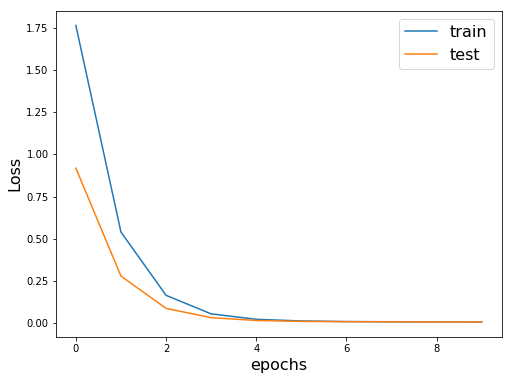

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='test')
ax.legend(fontsize=16)
ax.set_ylabel('Loss', fontsize=16)
ax.set_xlabel('epochs', fontsize=16)
fig.savefig('Figures/Loss_Uncertainty.png', dpi=200)

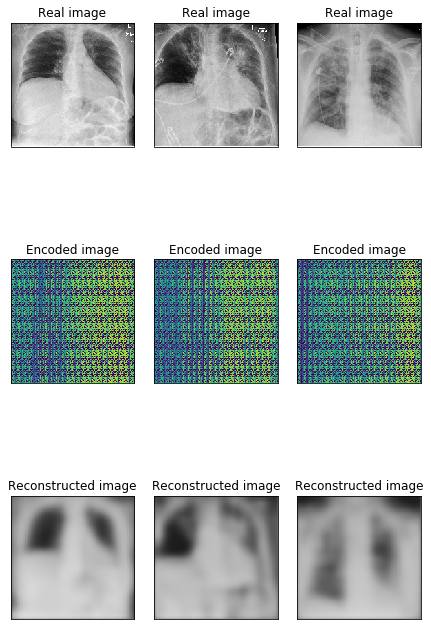

In [12]:
plt.figure(figsize=(20, 10))
for it in range(3):
    i = np.random.randint(0, len(encoder_imgs))
    ax = plt.subplot(3, 10, it+1)
    ax.imshow(X_test[i])
    plt.xticks(())
    plt.yticks(())
    ax.set_title('Real image')
    ax2 = plt.subplot(3, 10, it + 1 + 10)
    ax2.imshow(encoder_imgs[i].reshape(23*8, 23*8).T)
    plt.xticks(())
    plt.yticks(())
    ax2.set_title('Encoded image')
    ax3 = plt.subplot(3, 10, it + 1 + 2*10)
    ax3.imshow(decoder_imgs[i])
    plt.xticks(())
    plt.yticks(())
    ax3.set_title('Reconstructed image')
    plt.tight_layout()